In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
from datetime import timedelta
from IPython.display import Markdown as md
import matplotlib.pyplot as plt

## Import the Data

Let's grab the csv I got from OSCAR

In [2]:
df = pd.read_csv("data/sleeping_on_these_hoes.csv")
df.columns = ["timestamp", "session",'event','data_duration']
df.timestamp = pd.to_datetime(df.timestamp)
df

,timestamp,session,event,data_duration
0,2024-12-02 00:57:31,1733118960,Obstructive,11.00
1,2024-12-02 00:57:57,1733118960,Obstructive,13.00
2,2024-12-01 23:56:37,1733118960,Pressure,4.00
3,2024-12-02 00:04:21,1733118960,Pressure,4.00
4,2024-12-02 00:04:21,1733118960,Pressure,4.02
...,...,...,...,...
1895990,2025-08-30 06:36:50,1756553700,Pressure,4.00
1895991,2025-08-30 06:36:00,1756553700,EPAP,4.00
1895992,2025-08-30 06:36:50,1756553700,EPAP,4.00
1895993,2025-08-30 06:35:50,1756553700,FLG,0.00


## Learning about the data

Let's start by figuring out how long each session is



In [13]:
# get the start and end time of each session and create a session dataframe
session_df = (
    df.groupby("session")
    .timestamp.agg(["min", "max"])
    .rename(columns={"min": "start_ts", "max": "end_ts"})
)
# calculating the duration
session_df['duration'] = session_df.diff(axis=1)['end_ts']
session_df

,start_ts,end_ts,duration
session,,,
1733118960,2024-12-01 23:56:27,2024-12-02 01:05:27,0 days 01:09:00
1733205960,2024-12-03 00:06:52,2024-12-03 00:42:52,0 days 00:36:00
1733208840,2024-12-03 00:54:34,2024-12-03 03:26:34,0 days 02:32:00
1733293440,2024-12-04 00:24:44,2024-12-04 03:15:44,0 days 02:51:00
1733383200,2024-12-05 01:20:35,2024-12-05 04:37:35,0 days 03:17:00
...,...,...,...
1756464120,2025-08-29 05:42:41,2025-08-29 05:43:41,0 days 00:01:00
1756466101,2025-08-29 06:15:03,2025-08-29 06:16:03,0 days 00:01:00
1756466253,2025-08-29 06:17:35,2025-08-29 06:18:35,0 days 00:01:00


Because most of these occur overnight, I'm going to subtract 12 hours to make daily groupings easier

In [14]:
session_df['start_am'] = session_df.start_ts - timedelta(hours=12)
session_df['end_am'] = session_df.end_ts - timedelta(hours=12)

### Let's visualize!

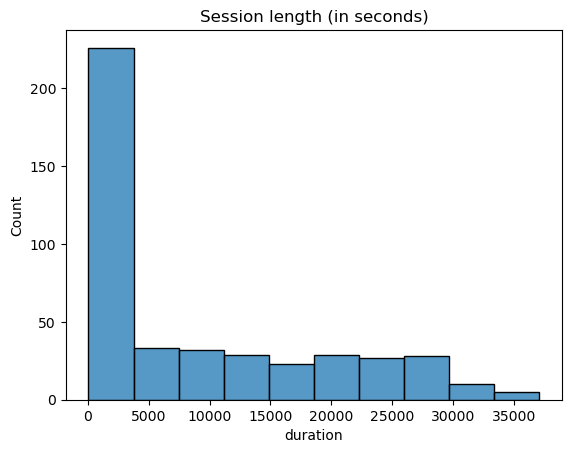

### average duration is 0 days 02:25:27.194570135

In [15]:
duration_hist = sns.histplot(session_df.duration.dt.seconds)
duration_hist.set_title("Session length (in seconds)")
plt.show()
display(md(f"### average duration is {session_df.duration.mean()}"))

OOOOOOkay....

So here's a lot of really short sessions (less than an hour and a half)
This is obviously going to require some more work. 

Normally, I would do some data-sciency things to this but considering the type of data we're looking at, I think it's safe to say that if the session has lasted less than 15 minutes, I almost certainly haven't fallen asleep in that time.

In [16]:
session_df = session_df[session_df.duration >= timedelta(minutes=15)]

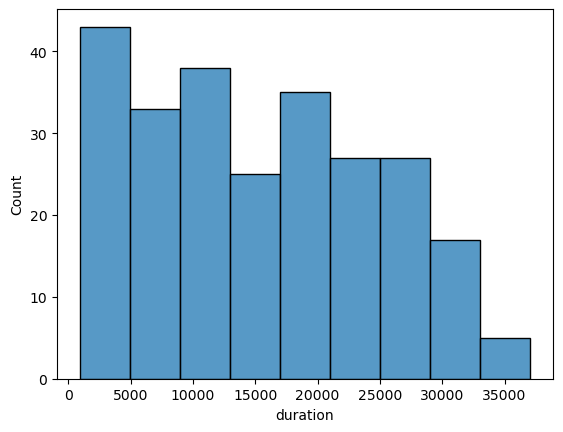

In [18]:
sns.histplot(session_df.duration.dt.seconds)
plt.show()

# Let's look at pressure events!

In [20]:
pressure_df = df[df.event == 'Pressure']
pressure_df

,timestamp,session,event,data_duration
2,2024-12-01 23:56:37,1733118960,Pressure,4.00
3,2024-12-02 00:04:21,1733118960,Pressure,4.00
4,2024-12-02 00:04:21,1733118960,Pressure,4.02
5,2024-12-02 00:04:23,1733118960,Pressure,4.02
6,2024-12-02 00:04:23,1733118960,Pressure,4.06
...,...,...,...,...
1890120,2025-08-30 06:04:05,1756526940,Pressure,7.72
1890121,2025-08-30 06:04:05,1756526940,Pressure,7.70
1890122,2025-08-30 06:04:17,1756526940,Pressure,7.70
1895989,2025-08-30 06:36:00,1756553700,Pressure,4.00


Let's look at my average nightly pressure

In [27]:
df.event.value_counts()

event
Pressure       945302
EPAP           908608
FLG             40242
Obstructive      1340
Apnea             171
ClearAirway       131
Hypopnea          118
RERA               83
Name: count, dtype: int64